In [49]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Additional Libraries
from pypfopt import EfficientFrontier

# Included in Python
import random
from datetime import datetime
from typing import Tuple, List  # For documentation
import time

Required libraries:
- pandas
- numpy
- yfinance
- matplotlib
- pypfopt

To install pypfopt, type
```
pip install PyPortfolioOpt
```

## Group Assignment
### Team Number: 02
### Team Member Names: Jason, Patrick, Gateek
### Team Strategy Chosen: Market Beat

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.


### Step 1: Filter stocks based on requirements
In this section, we will remove stocks that do not meet the requirements laid out. The first function only return stocks that exist and trade in USD/CAD.

In [50]:
def valid_stocks(tickers_file):
    """
    Filters and returns a list of valid stock tickers based on specific restrictions:
    - The stock must trade in USD or CAD.
    - The stock must have an average monthly volume above 100,000 shares.
    - The stock must have at least 18 valid trading days per month.

    Parameters:
        tickers_file (str): Path to a CSV file containing stock tickers under a column named 'Tickers'.

    Returns:
        list of str: A list of valid stock tickers that meet the specified criteria.

    Example:
        valid_tickers = valid_stocks('Tickers_Example.csv')
    """

    # Read CSV and extract tickers
    tickers_df = pd.read_csv(tickers_file)

    if tickers_df.empty:  # If the file is empty, return nothing
        return []
    
    # Rename columns to ensure consistency
    first_stock = []
    first_stock.append(tickers_df.columns[0])
    rest_stock = tickers_df.iloc[:, 0].tolist()
    tickers_list = first_stock + rest_stock
    # Remove duplicates 
    tickers_list = list(set(tickers_list))

    # Define the date range for historical data
    start = '2023-10-01'
    end = '2024-09-30'

    valid_tickers = []  # List to store valid tickers

    # Process each ticker in the list
    for ticker in tickers_list:
        # Load ticker info using yfinance
        stock = yf.Ticker(ticker)
        info = stock.fast_info

        # Filter ticker by currency
        try:
            currency = info['currency']
        except Exception:  # Skip ticker if currency info is unavailable
            print(ticker, " was removed because it either does not exist, or has been delisted", sep='')
            continue

        if currency not in ['USD', 'CAD']:  # Only allow USD or CAD stocks
            print(ticker, " was removed because it is not a Canadian or US stock.", sep='')
            continue

        # Filter ticker by average monthly volume and trading days
        try:
            hist = stock.history(start=start, end=end, interval='1d')
            time.sleep(0.3)
        except Exception:  # Skip ticker if historical data is unavailable
            print(ticker, " was removed because it either does not exist, or has been delisted", sep='')
            continue

        # NEW CODE ----------
        if hist.empty:
            print(ticker, " was removed because it does not have valid hist data", sep='')
            continue

        # Calculate monthly trading statistics
        monthly_volume = pd.DataFrame()
        monthly_volume['volume'] = hist['Volume'].resample('ME').sum()
        monthly_volume['count'] = hist['Volume'].resample('ME').count()
        monthly_volume['avg monthly volume'] = monthly_volume['volume'] / monthly_volume['count']

        # Check for months with insufficient trading days or low average volume
        invalid_trading_days = monthly_volume[monthly_volume['count'] < 18]
        invalid_monthly_vol = monthly_volume[monthly_volume['avg monthly volume'] < 100000]

        # Skip tickers that fail the volume or trading day criteria
        if len(invalid_monthly_vol) > 0 or len(invalid_trading_days) > 0:
            print(ticker, " was removed because it does not have a monthly trading volume of 100,000 or a valid amount of trading days.", sep='')
            continue

        # Add valid ticker to the list
        valid_tickers.append(ticker)

    return valid_tickers

# Example usage
valid_tickers = valid_stocks('Tickers.csv')
print("Here all all the tickers that passed the valid requirements associated with the assignment details: ", valid_tickers, sep='')

$INVALIDTIC: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


INVALIDTIC was removed because it either does not exist, or has been delisted
GC=F was removed because it does not have a monthly trading volume of 100,000 or a valid amount of trading days.
AUST was removed because it does not have a monthly trading volume of 100,000 or a valid amount of trading days.


$HDFC.NS: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


HDFC.NS was removed because it either does not exist, or has been delisted


$AW.TO: possibly delisted; no price data found  (1d 2023-10-01 -> 2024-09-30) (Yahoo error = "Data doesn't exist for startDate = 1696132800, endDate = 1727668800")


AW.TO was removed because it does not have valid hist data


$ASDFAASDF.TO: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


asdfaasdf.to was removed because it either does not exist, or has been delisted


$CELG: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


CELG was removed because it either does not exist, or has been delisted
Here all all the tickers that passed the valid requirements associated with the assignment details: ['SQ', 'SHOP.TO', 'TD.TO', 'RY.TO', 'SPG', 'CMCSA', 'GOOG', 'VZ', 'CSCO', 'JPM', 'SO', 'AAPL', 'SLB', 'T.TO', 'PEP', 'BK', 'IBM', 'AMZN', 'OXY', 'LOW', 'ABBV', 'COST', 'HOOD', 'AXP', 'SHOP', 'DUOL', 'ORCL', 'CVS', 'GM', 'BAC']


### Step 2: Get close prices for all stocks
This function will the remaining stocks have enough history and also converts all stocks in USD ot CAD.

In [51]:
def get_close_prices(start, end, tickers, cutoff):
    """
    Retrieves historical close prices for specified stocks and converts them to CAD.
    Filters out stocks that do not have data available before the cutoff date. The returned 
    data starts from the date when the youngest valid stock began tracking close prices.

    Parameters:
        start (str): The start date for fetching historical data (format: 'YYYY-MM-DD').
        end (str): The end date for fetching historical data (format: 'YYYY-MM-DD').
        tickers (list of str): A list of stock ticker symbols to fetch data for.
        cutoff (str): The cutoff date (format: 'YYYY-MM-DD'). Stocks without data before this date are excluded.

    Returns:
        pd.DataFrame: A DataFrame containing the close prices of valid stocks (in CAD), starting from
                      the earliest available date for all valid stocks.

    Restrictions:
        - `start` must be less than `cutoff`, and `cutoff` must be less than `end`.

    Example:
        close_prices = get_close_prices('2020-01-01', '2024-01-01', ['AAPL', 'NVDA'], '2022-01-01')
    """

    multi_data = pd.DataFrame()  # Final DataFrame to hold valid tickers
    df = []  # Temporary list to hold individual stock close price series
    appended_tickers = []  # List of valid tickers that meet the cutoff condition

    # Loop through tickers
    for ticker in tickers:
        # Get historical data for the ticker
        data = yf.download(ticker, start=start, end=end, interval='1d')
        time.sleep(0.3)
        close = data['Close']
       #close = close.rename(ticker)  # Rename series to match the ticker symbol

        # Check if the stock has data before the cutoff date
        if close.index.min() < pd.Timestamp(cutoff):
            # Add the stock's close prices to the list
            df.append(close)
            appended_tickers.append(ticker)
        else:
            print(ticker, " was removed because it did not exist before ", cutoff,  sep='')

    # Combine all valid stock close prices into a single DataFrame
    multi_data = pd.concat(df, axis=1)

    # Drop rows with missing data to ensure consistent data points for all tickers
    multi_data.dropna(subset=appended_tickers, inplace=True)

    # Get CAD to USD exchange rate data
    cadusd = yf.download('CAD=X', start=start, end=end, interval='1d')
    time.sleep(0.3)
    aligned_cadusd = cadusd.reindex(multi_data.index, method='ffill')
    aligned_cadusd_close = aligned_cadusd['Close'].reindex(multi_data.index)

    # Convert all stock prices to CAD
    for ticker in appended_tickers:
        stock = yf.Ticker(ticker)
        info = stock.fast_info

        # Check the currency of the stock
        currency = info['currency']
        if currency == 'USD':  # If the stock is in USD, convert it to CAD
            combined = pd.concat([multi_data[ticker], aligned_cadusd_close], axis=1).dropna()
            # convert USD to CAD
            multi_data[ticker] = combined.iloc[:, 0] * combined.iloc[:, 1]
            #multi_data[ticker] = multi_data[ticker] * aligned_cadusd['Close']
            break
    
    return multi_data

# Example usage
start = '2015-01-01'
end = '2024-11-22'
cutoff = '2019-01-01'
close_prices = get_close_prices(start, end, valid_tickers, cutoff)
valid_tickers = close_prices.columns

display(close_prices.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

HOOD was removed because it did not exist before 2019-01-01


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


DUOL was removed because it did not exist before 2019-01-01


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Ticker,SQ,SHOP.TO,TD.TO,RY.TO,SPG,CMCSA,GOOG,VZ,CSCO,JPM,...,OXY,LOW,ABBV,COST,AXP,SHOP,ORCL,CVS,GM,BAC
Date,,,,,,,,,,,,,,,,,,,,,
2015-11-19,17.381793,3.918,54.619999,76.160004,191.039993,31.309999,36.920502,45.759998,27.370001,67.660004,...,75.171989,73.389999,60.549999,162.830002,72.739998,2.945,39.020000,92.489998,36.139999,17.690001
2015-11-20,17.084590,3.762,54.580002,76.070000,192.229996,31.450001,37.830002,45.389999,27.570000,67.540001,...,73.964050,75.769997,61.110001,163.100006,72.419998,2.823,39.340000,91.930000,36.340000,17.650000
2015-11-23,16.187715,3.874,54.500000,75.489998,191.089996,31.065001,37.799000,44.990002,27.430000,66.879997,...,73.974030,76.669998,61.150002,163.449997,72.239998,2.887,39.139999,91.559998,36.080002,17.469999
2015-11-24,16.059081,3.598,54.430000,75.260002,187.240005,30.830000,37.414001,45.189999,27.270000,66.779999,...,75.770973,77.389999,61.130001,162.190002,71.629997,2.695,39.459999,92.250000,36.220001,17.469999
2015-11-25,15.830569,3.524,54.330002,75.230003,188.490005,30.700001,37.407501,44.919998,27.240000,66.860001,...,75.251854,77.610001,60.290001,162.389999,71.690002,2.644,39.259998,93.900002,36.340000,17.440001


### Step 3: Remove poor performing stocks.

Now, we want to remove stocks that would not provide any value to a portfolio, either because they have too much risk without much return, or too much return without much risk. We only want stocks that have high risk with high returns, or low returns with low risk. This is with the assumption that there will be decent stocks after this filter that have varying amounts of correlation with each other.

In [52]:
def keep_tickers(dataframe, list):
    """
    This function, given a dataframe and list of tickers, will keep
    all items in the dataframe with a ticker in the list. Tickers must be in
    the Dataframe

    :param dataframe: pd.DataFrame
    :param list: list[Str]
    :return: pd.DataFrame
    """

    newframe = pd.DataFrame()

    for i in list:
        newframe[i] = dataframe[i]

    return newframe

In [53]:
def stock_df_to_ticker(dataframe):
    """
        This function, when given a dataframe of stocks, will return a list of ticker strings

        :param dataframe: dataframe
        :return: list[str]
        """

    ticker_list = []

    for i in dataframe.index:
        ticker_list.append(i)

    return ticker_list

This function aims to add diversity to our stocks to reduce risk. It does so by finding stocks that are too correlated with others, and removes them.

In [54]:
def correlation_filter(prices: pd.DataFrame, max_corr: float):
    """
    This function, when given a dataframe of prices and returns stocks that are not too correlated.

    :param prices: pd.DataFrame
    :param max_corr: float
    :return: list[Str]
    """
    correlations = prices.corr()

    tickers = []

    corr_list = correlations.index

    avg_corr_df = pd.DataFrame(columns = ['Correlation'])

     #add to a dataframe

    for i in corr_list:
        avg_corr_df.loc[i, 'Correlation'] = correlations.loc[i].mean()

    avg_corr_df = avg_corr_df.sort_values('Correlation', ascending = False)

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 12)
    bar_container = ax.bar(avg_corr_df.index, avg_corr_df.Correlation)
    ax.set(ylabel='Average Correlation', title='Average Stock Correlation')

    ax.set_xticks = avg_corr_df.index
    ax.set_xticklabels(avg_corr_df.index, rotation=45)

    #display(avg_corr_df)

    corr_list = avg_corr_df.index

    i = 0
    
    #filter - checks the stocks near the beginning, so 
    while i < len(avg_corr_df.index):
        index = avg_corr_df.index[i]
        tick = corr_list[i]
        
        if avg_corr_df.loc[tick, 'Correlation'] <= max_corr or len(corr_list) - i <= 12:
            tickers.append(tick)
            i += 1
        else:
            print(tick + " was removed since its correlation with other stocks was too high. (" 
                  + str(np.round(avg_corr_df.loc[tick, 'Correlation'], 2)) + ")")
            i += 1
    return tickers

/var/folders/7f/785d69cd4r94q3p9ft0h1nxr0000gn/T/ipykernel_25007/3123721772.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(avg_corr_df.index, rotation=45)


,JPM,BAC,AXP,RY.TO,BK,TD.TO,CSCO,AAPL,LOW,IBM,...,SQ,AMZN,COST,OXY,CVS,SO,SHOP,ABBV,VZ,SHOP.TO
Date,,,,,,,,,,,,,,,,,,,,,
2015-11-20,-0.001774,-0.002261,-0.004399,-0.001182,-0.002053,-0.000732,0.007307,0.004378,0.032429,0.012871,...,-0.017099,0.010858,0.001658,-0.016069,-0.006055,0.001328,-0.041426,0.009249,-0.008086,-0.039816
2015-11-23,-0.009772,-0.010198,-0.002486,-0.007625,-0.001600,-0.001466,-0.005078,-0.012992,0.011878,-0.000289,...,-0.052496,0.015768,0.002146,0.000135,-0.004025,-0.007073,0.022671,0.000655,-0.008812,0.029771
2015-11-24,-0.001495,0.000000,-0.008444,-0.003047,0.000229,-0.001284,-0.005833,0.009597,0.009391,0.001011,...,-0.007946,-0.011547,-0.007709,0.024292,0.007536,-0.002449,-0.066505,-0.000327,0.004445,-0.071244
2015-11-25,0.001198,-0.001717,0.000838,-0.000399,0.005723,-0.001837,-0.001100,-0.007150,0.002843,-0.004329,...,-0.014229,0.006243,0.001233,-0.006851,0.017886,-0.005133,-0.018924,-0.013741,-0.005975,-0.020567
2015-11-27,0.004637,0.002294,0.002232,0.000266,-0.001138,0.002761,0.002937,-0.001864,-0.003479,0.003333,...,0.011950,-0.003080,0.007328,-0.002521,0.007774,0.000000,0.010212,-0.004810,0.006901,0.027242


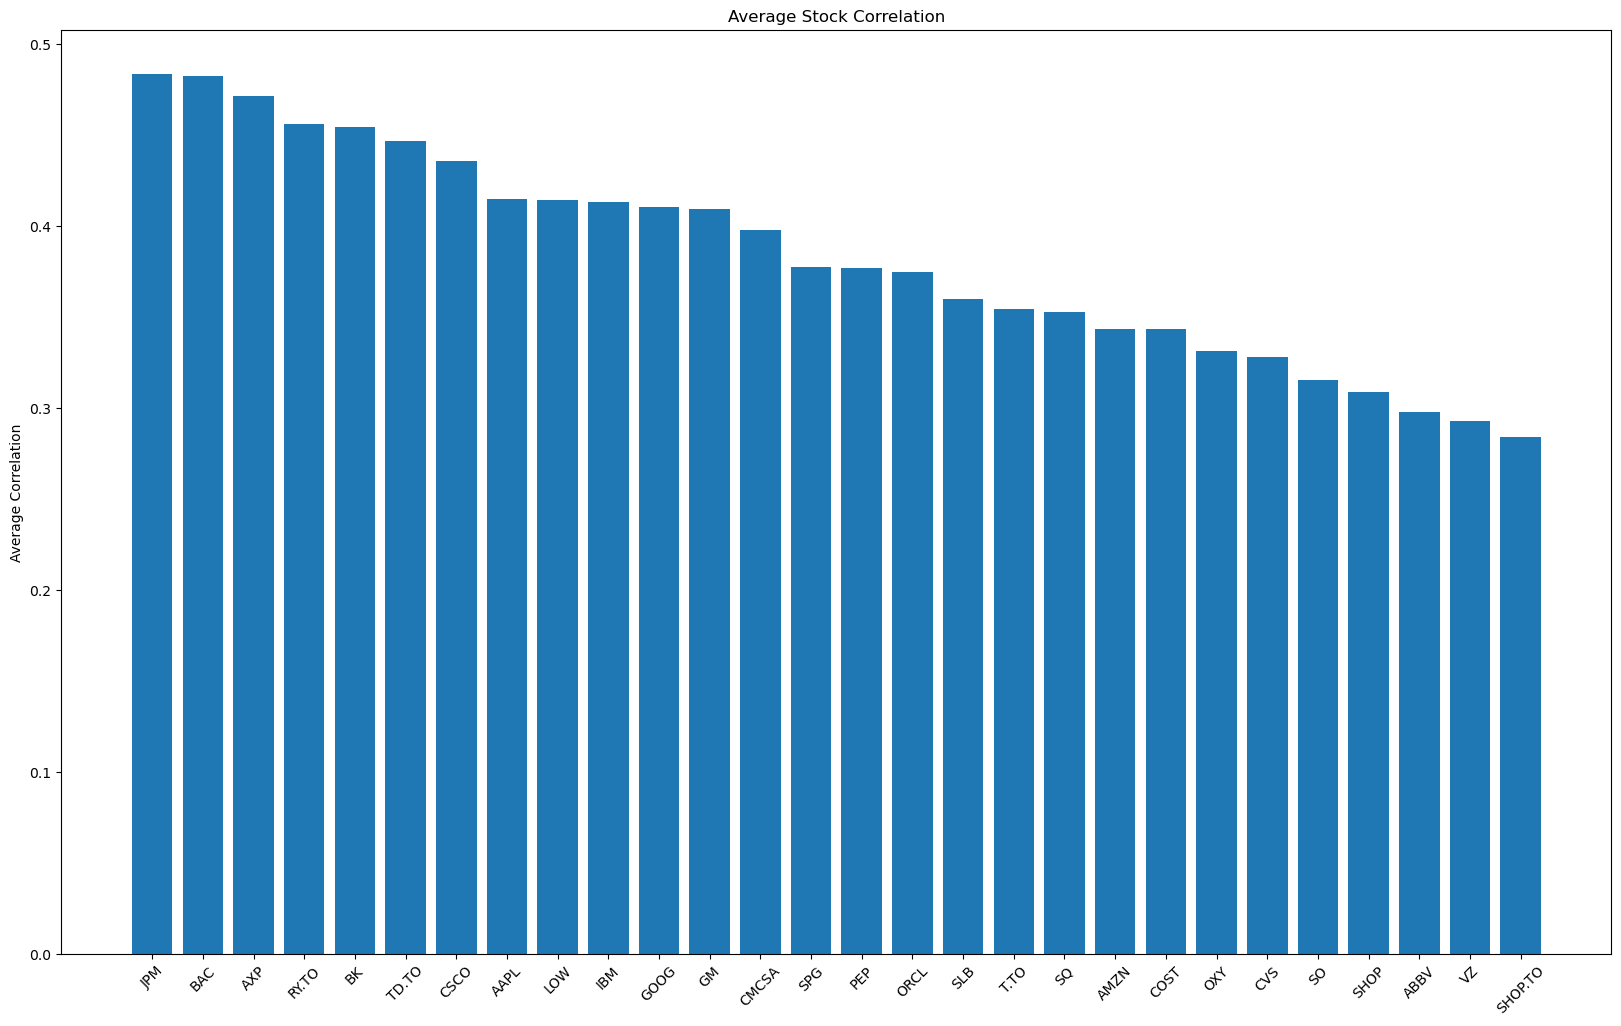

In [55]:
def convertToPct(df):
    """
    Converts a stock dataframe to percentage changes
    :param df: pd.DataFrame
    :return: pd.DataFrame
    """
    pct_df = df.pct_change(fill_method=None)
    # Drop first row
    pct_df.drop(index=pct_df.index[0], inplace=True)
    return pct_df

stock_pct_change = convertToPct(close_prices)
stock_pct_change = keep_tickers(stock_pct_change, correlation_filter(stock_pct_change, 0.5))

display(stock_pct_change.head())

The first round of elimination is identifying the stocks that have too high of an average correlation with the other stocks in the portfolio. So, as discussed in our Portfolio unit, we want stocks that are diversified, so we do not want to hold stocks that have too similar of a correlation with the rest of the portfolio. If the stocks in our portfolio are too closely correlated, it could result in one event causing our entire portfolio to lose value, so by having lowly correlated stocks, we can prevent that. 

VZ was removed because its Sharpe ratio was too low. ( 0.0593 )
SLB was removed because its Sharpe ratio was too low. ( 0.048 )
CVS was removed because its returns were too low. ( -0.0001 )


/var/folders/7f/785d69cd4r94q3p9ft0h1nxr0000gn/T/ipykernel_25007/2159022691.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sharpe_df.index, rotation=45)


,Returns,Std,Sharpe
COST,0.000897,0.014072,1.012006
SHOP.TO,0.002288,0.036060,1.007090
SHOP,0.002307,0.037212,0.984279
AAPL,0.001085,0.018182,0.947577
AMZN,0.001023,0.020790,0.781462
ORCL,0.000877,0.017833,0.780691
GOOG,0.000848,0.017952,0.749533
SQ,0.001588,0.036872,0.683889
JPM,0.000738,0.017811,0.657422
AXP,0.000828,0.020136,0.653104


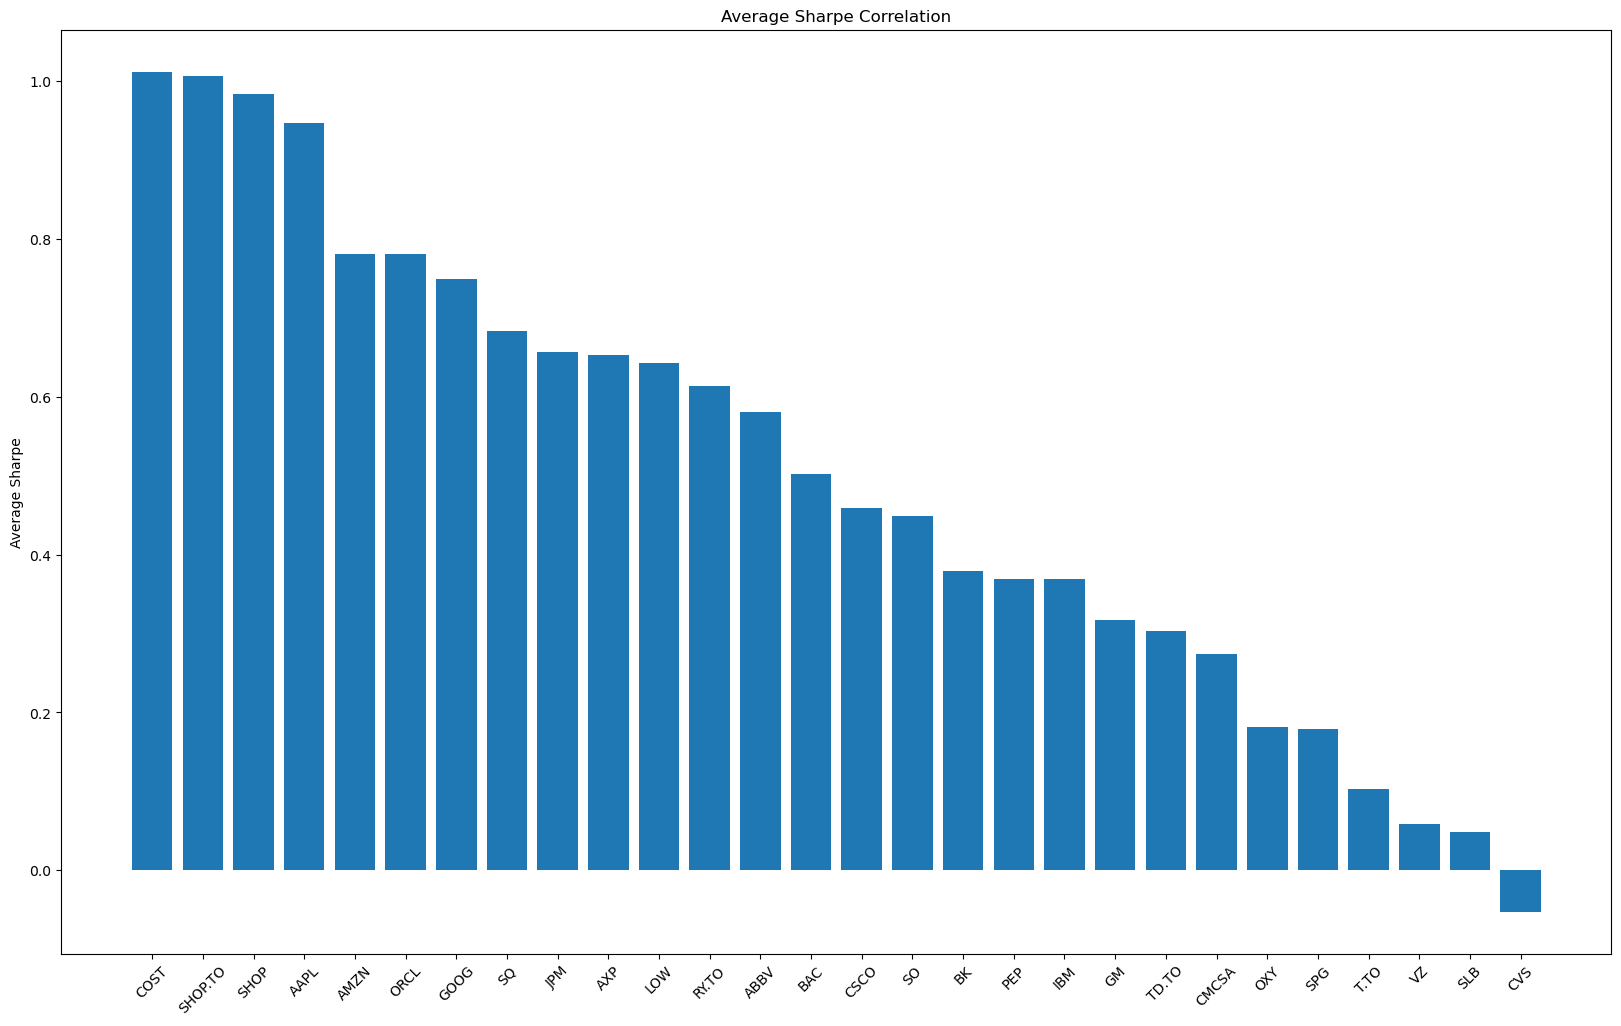

In [56]:
#feed pct_change() data
def sort_by_sharpe(price_pct, min_sharpe, min_return, max_std):
    """
        This function, when given a dataframe of
        price percent change, a dataframe of prices, a minimum sharpe ratio, a minimum return
        and maximum standard deviation will produce a dataframe with the returns, standard deviation
        sharpe ratio and prices of all stocks in the given dataframe that meets the set criteria

        :param price_pct: dataframe
        :param min_sharpe: float
        :param min_return: float
        :param: max_std: float
        :return: dataframe
        """

    sharpe_df = pd.DataFrame(columns=['Returns', 'Std', 'Sharpe'])
    returns = 0
    std = 0
    ticker = ""

    stock_info = {}#fixed length list of Ticker, Returns, Std, Sharpe

    tick_list = price_pct.columns

    for i in range(len(tick_list)):
        ticker = tick_list[i]

        #work out equations - pct_change() on all,
        returns = price_pct[ticker].mean()

        #work out equations
        std = price_pct[ticker].std()

        #multiply sharpe_ratio by sqrt(15), or the number of weeks
        sharpe = returns/std * (252 ** 0.5)

        #print(ticker, sharpe, returns, std)
        stock_info = {
            'Returns': returns,
            'Std': std,
            'Sharpe': sharpe
        }

        # stock_info = pd.DataFrame(stock_info)

        sharpe_df.loc[ticker] = stock_info

    sharpe_df = sharpe_df.sort_values('Sharpe', ascending = False)

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 12)
    bar_container = ax.bar(sharpe_df.index, sharpe_df.Sharpe)
    ax.set(ylabel='Average Sharpe', title='Average Sharpe Correlation')

    ax.set_xticks = sharpe_df.index
    ax.set_xticklabels(sharpe_df.index, rotation=45)

    #print(sharpe_df)

    #filter out the bad stocks from after the last 12 stocks, this ensures that only the worse stocks get removed. 

    i = 12

    while i < len(sharpe_df.index):
        index = sharpe_df.index[i]
        
        if sharpe_df.loc[index, 'Returns'] < min_return :
            print(index + " was removed because its returns were too low. (", np.round(sharpe_df.loc[index, 'Returns'], 4), ")")
            sharpe_df.drop(index=index, inplace=True)
        elif sharpe_df.loc[index, 'Std'] > max_std:
            print(index + " was removed because its risk was too high. (", np.round(sharpe_df.loc[index, 'Std'], 4), ")")
            sharpe_df.drop(index=index, inplace=True)
        elif sharpe_df.loc[index, 'Sharpe'] < min_sharpe:
            print(index + " was removed because its Sharpe ratio was too low. (", np.round(sharpe_df.loc[index, 'Sharpe'], 4), ")")
            sharpe_df.drop(index=index, inplace=True)
            
        else:
            i+= 1

    return sharpe_df

stock_sharpe = sort_by_sharpe(stock_pct_change, 0.1, 0, 1)
display(stock_sharpe)

At this step of algorithm, we sort a dataframe by their sharpe values and remove any stock whose returns or sharpe values are too low. This is to ensure that the stocks that we have are a good investment. Additionally, stocks that have too high of a risk might be removed as well. Essentially, we want to have stocks that provide positive returns and meet our criteria for our stocks.

In the event that there at not 12 stocks that meet our criteria, we take the 12 that best meet our criteria.

In [57]:

def arrange_by_sharpe(prices:pd.DataFrame, sharpe:pd.DataFrame):
    """
    This function, when given how long the list will be and categorization of stocks,
    will return a list of stocks that we want to craft the portfolio from.
    :param prices: pd.DataFrame
    :param sharpe: pd.DataFrame
    :return: pd.DataFrame
    """
    new_prices = pd.DataFrame()

    for i in sharpe.index:
        new_prices[i] = prices[i]

    return new_prices

best_stock = stock_sharpe.index[0]

print("Our best stock is " + best_stock)

stock_prices = arrange_by_sharpe(close_prices, stock_sharpe)

Our best stock is COST


No actual filtering occurs here, we only just shrink the list of prices to only contain the list of stocks that we wish to use.

In [58]:
def categorize(df:pd.DataFrame, pivot:str, categories:int):
    """
    Categorizes stocks into different categories depending on how correlated they are
    :param df: pd.DataFrame, must have pct data
    :param pivot: string that is in df
    :param categories: int
    :return: list[list[str]]
    """
    correlations = df.corr()
    lin_space = np.linspace(0, 0.9999999, categories + 1)[1:]
    # The 0.999999 prevents adding the stock itself into the list
    stock_categories = []

    for i in range(categories):
        stock_categories.append([])

    for stock in correlations.index:

        correlation = correlations.at[pivot, stock]
        inserted = False
        i = 0
        while i < categories and not inserted:
            if correlation <= lin_space[i]:
                stock_categories[i].append(stock)
                inserted = True
            i = i + 1
    return stock_categories

stock_correlation_tiers = categorize(stock_prices, best_stock, 10)
display(stock_correlation_tiers)

[['OXY', 'SPG'],
 [],
 ['SQ'],
 ['GM', 'CMCSA', 'T.TO'],
 ['BK', 'IBM'],
 ['SHOP.TO', 'SHOP'],
 ['BAC', 'CSCO', 'TD.TO'],
 [],
 ['AMZN', 'JPM', 'PEP'],
 ['AAPL', 'ORCL', 'GOOG', 'AXP', 'LOW', 'RY.TO', 'ABBV', 'SO']]

Next, we categorize the stocks we wish to build our portfolio from based on how closely correlated they are to our best stock. Additionally, each subcategory is sorted by Sharpe ratio. This prepares our program to select the best stocks so that the stocks contained in the portfolio are not too highly correlated with the other stocks, and that the stocks with higher sharpe ratios are chosen before stocks with lower sharpe ratios.

In [59]:
def filtering(list_len, stock_correlation_tiers):
    """
    This function, when given how long the list will be and categorization of stocks,
    will return a list of stocks that we want to craft the portfolio from.
    :param list_len: int
    :param stock_correlation_tiers: list[list[str]]
    :return: list[str]
    """
    ticker_list = []

    while 0 < len(stock_correlation_tiers) and len(ticker_list) < list_len:
        sub_list = stock_correlation_tiers[0]
        while 0 < len(sub_list) and len(ticker_list) < list_len:
            #print(sub_list[0])
            ticker_list.append(sub_list[0])
            sub_list.pop(0)

        stock_correlation_tiers.pop(0)
    
    return ticker_list

ticker_lst = [best_stock]
ticker_lst += filtering(23, stock_correlation_tiers)
print(ticker_lst)
# We modify the original close prices to contain the tickers we want.
stock_close_prices = keep_tickers(close_prices, ticker_lst)  
display(stock_close_prices.head())

['COST', 'OXY', 'SPG', 'SQ', 'GM', 'CMCSA', 'T.TO', 'BK', 'IBM', 'SHOP.TO', 'SHOP', 'BAC', 'CSCO', 'TD.TO', 'AMZN', 'JPM', 'PEP', 'AAPL', 'ORCL', 'GOOG', 'AXP', 'LOW', 'RY.TO', 'ABBV']


,COST,OXY,SPG,SQ,GM,CMCSA,T.TO,BK,IBM,SHOP.TO,...,AMZN,JPM,PEP,AAPL,ORCL,GOOG,AXP,LOW,RY.TO,ABBV
Date,,,,,,,,,,,,,,,,,,,,,
2015-11-19,162.830002,75.171989,191.039993,17.381793,36.139999,31.309999,20.924999,43.830002,130.726578,3.918,...,33.063499,67.660004,100.930000,29.695000,39.020000,36.920502,72.739998,73.389999,76.160004,60.549999
2015-11-20,163.100006,73.964050,192.229996,17.084590,36.340000,31.450001,20.885000,43.740002,132.409180,3.762,...,33.422501,67.540001,100.099998,29.825001,39.340000,37.830002,72.419998,75.769997,76.070000,61.110001
2015-11-23,163.449997,73.974030,191.089996,16.187715,36.080002,31.065001,20.695000,43.669998,132.370941,3.874,...,33.949501,66.879997,100.849998,29.437500,39.139999,37.799000,72.239998,76.669998,75.489998,61.150002
2015-11-24,162.190002,75.770973,187.240005,16.059081,36.220001,30.830000,20.665001,43.680000,132.504776,3.598,...,33.557499,66.779999,100.629997,29.719999,39.459999,37.414001,71.629997,77.389999,75.260002,61.130001
2015-11-25,162.389999,75.251854,188.490005,15.830569,36.340000,30.700001,20.730000,43.930000,131.931168,3.524,...,33.766998,66.860001,100.500000,29.507500,39.259998,37.407501,71.690002,77.610001,75.230003,60.290001


In the filtering step, we cycle through each tier of stock correlation and add them to the list of stocks we wish to buy. This continues until we have 24 stocks (or less, if stocks we have are weak). We hope this creates some diversification with our stocks while allowing for some additional return to have more stocks. 

We should already have diversification. One thing that is hard to predict though, is whether a stock will have good returns in the near future. We can implement some ideas from technical analysis. One of these ways is through moving averages, where we keep track of a longer-term average and a shorter-term average. In this case, we keep track of a one month average and weekly average. If the weekly average crosses over the monthly average, it could indicate that the stock is on an upward trend. On the other hand, if it goes under, it indicates a downward trend. 

To implement this, we take a more simplistic approach. In essence, we take short-term average - long-term average. If it is positive, we keep the stock. Else, we put it aside and take it if we need it to make up more than 12 stocks.

This process may remove some of the diversified stocks. However, we already 24 stocks with varying correlations and even if we only choose 12, there should still be stocks that are both lowly correlated and highly correlated. Therefore, we still keep some diversification.

In [60]:
#last month vs. last week
def movingAvg(prices, long_interval, short_interval):
    """
    This function, when given a dataframe of prices, and interval
    will return a dataframe of the moving average of the prices covering the listed interval

    :param prices: dataframe
    :param long_interval: int
    :param short_interval: int
    :return: dataframe
    """

    averaged_prices = pd.DataFrame(columns = ['long', 'short', 'difference'])

    for stock in prices.columns:  # do it for all the stocks
        sum_long = 0  # Keep track of the long term average
        num_days = prices.index.size

        for i in range(long_interval):
            sum_long += prices.loc[prices.index[num_days-i-1], stock]

        sum_long = sum_long / long_interval
        averaged_prices.loc[stock, 'long'] = sum_long

        sum_short = 0  # Keep track of the short term average
        num_days = prices.index.size

        for i in range(short_interval):
            sum_short += prices.loc[prices.index[num_days - i-1], stock]

        sum_short = sum_short / short_interval  
        averaged_prices.loc[stock, 'short'] = sum_short
        # We take an average 
        averaged_prices.loc[stock, 'difference'] = (averaged_prices.loc[stock, 'short'] - averaged_prices.loc[stock, 'long'])/ prices.loc[prices.index[num_days-1], stock]

    averaged_prices = averaged_prices.sort_values('difference', ascending=False)

    return averaged_prices


moving_averages = movingAvg(stock_close_prices, 20, 5)  # Moving averages for a month and a week
display(moving_averages)

,long,short,difference
SHOP.TO,128.519999,148.3,0.132921
SHOP,92.079,105.875999,0.129574
SQ,111.549505,126.135811,0.11265
BAC,44.378,46.48,0.045243
JPM,234.125999,243.793997,0.0395
ORCL,181.348,188.309998,0.036179
SPG,176.046501,181.008005,0.027291
GM,54.545,55.79,0.02236
AXP,281.895,287.733997,0.019928
COST,909.815503,928.092017,0.019125


The following functions will then choose the postive ones or the top fifteen. We choose the top fifteen just to be safe with the project requirements.

In [61]:
amount_top = 15
top_stocks = moving_averages.iloc[:amount_top].index.values.tolist()

for i in range(amount_top, len(moving_averages)):
    if moving_averages["difference"].iloc[i] < 0:  # if the difference is still greater than 0
        break  # No more to see
    else:
        top_stocks.append(moving_averages.index[i])

# Then, we add modify the stock close prices list
stock_close_prices = keep_tickers(stock_close_prices, top_stocks)  
display(stock_close_prices.head())

,SHOP.TO,SHOP,SQ,BAC,JPM,ORCL,SPG,GM,AXP,COST,BK,CSCO,AMZN,IBM,TD.TO,AAPL,OXY,RY.TO
Date,,,,,,,,,,,,,,,,,,
2015-11-19,3.918,2.945,17.381793,17.690001,67.660004,39.020000,191.039993,36.139999,72.739998,162.830002,43.830002,27.370001,33.063499,130.726578,54.619999,29.695000,75.171989,76.160004
2015-11-20,3.762,2.823,17.084590,17.650000,67.540001,39.340000,192.229996,36.340000,72.419998,163.100006,43.740002,27.570000,33.422501,132.409180,54.580002,29.825001,73.964050,76.070000
2015-11-23,3.874,2.887,16.187715,17.469999,66.879997,39.139999,191.089996,36.080002,72.239998,163.449997,43.669998,27.430000,33.949501,132.370941,54.500000,29.437500,73.974030,75.489998
2015-11-24,3.598,2.695,16.059081,17.469999,66.779999,39.459999,187.240005,36.220001,71.629997,162.190002,43.680000,27.270000,33.557499,132.504776,54.430000,29.719999,75.770973,75.260002
2015-11-25,3.524,2.644,15.830569,17.440001,66.860001,39.259998,188.490005,36.340000,71.690002,162.389999,43.930000,27.240000,33.766998,131.931168,54.330002,29.507500,75.251854,75.230003


Finally, reduce the number of stock prices that we have in our dataframe to contain the close prices of only the stocks we wish to keep.

# Finding the Weightings
In this section, we will try to find the optimal weightings with the stocks that have been chosen. We will be implementing ideas from Modern Portfolio Theory. In the next section, we will go over the theory behind this model. Then, we will implement our ideas to create a portfolio that meets our needs.

## Explanation
The main assumption behind the Markowitz Model is that investors are willing to accept more risk if they get more returns. In other words, the best portfolio is the one that provides the most returns for the same amount of risk. 

Firstly, we will plot out a portfolio that assigns random weightings to random stocks. We plot the returns on a scatter graph.

Note that the following code is only an example and is not coded to be dynamic. We include a dynamic implementation in the section after.

The following functions will help simulate the randomly-weighted portfolio. The first function will return the results of a portfolio. The second function is to generate a list of weightings that add up to one. The third function will return a dataframe with those weightings applied. The fourth function gets the risk and returns of these random portfolios. The fifth function will plot it out.

In [62]:
def getPortfolioResults(df: pd.DataFrame) -> Tuple:
    # Returns the average returns and standard deviation of the portfolio
    pf_value = df.sum(axis=1)
    pct_df = convertToPct(pf_value)
    avg_returns = pct_df.mean()
    std = pct_df.std()
    return avg_returns, std


def getRandomWeightings(length: int, min_weight: float = 0) -> List[float]:
    # Returns a list of random weightings
    # Requires that the min_weight * len <= 1
    weightings_lst = np.random.random(size=length)  # Find random weightings
    # Make sure weightings_lst sums up to weight remainder
    weightings_lst /= np.sum(weightings_lst)
    weightings_lst *= 1 - min_weight
    weightings_lst += min_weight
    return weightings_lst.tolist()
# Example:
print("Test random weightings:", getRandomWeightings(len(close_prices.columns), 0))


def applyWeightings(df: pd.DataFrame, weightings: list, investment: int) -> pd.DataFrame:
    # Returns the dataframe adjusted for all the weightings
    # Requires that df has the same number of rows as the length of weightings
    i = 0
    for column in df.columns.values:
        # find shares
        shares = investment / df[column].iloc[0]
        df[column] *= shares * weightings[i]
        i = i + 1
    return df
# Example
test_df = stock_close_prices.copy()
test_df = applyWeightings(test_df, getRandomWeightings(len(test_df.columns)), 1000000)
display(test_df.head())


def simulateRandom(tests: int, stock_data: pd.DataFrame) -> Tuple[list, list, float, float]:
    test_data = stock_data.copy()
    # Simulates tests amount of tests with random weightings
    stocks_amount = len(test_data.columns)
    results = [[], [], []]
    min_std = 1000  # We want to find the minimum and maximum standard deviations later
    max_std = -1000
    weighting_record = []
    for test in range(tests):  # simulate a set amount of tests
        weightings = getRandomWeightings(stocks_amount, 0.03)
        weighted_df = applyWeightings(test_data, weightings, 1000000)  # Find df with weightings
        avg_return, std = getPortfolioResults(weighted_df)  # Find metrics for performance
        results[0].append(avg_return)
        results[1].append(std)
        results[2].append(avg_return / std * (252 ** 0.5))  
        min_std = min(std, min_std)
        max_std = max(std, max_std)
        weighting_record.append(weightings)
    return results, weighting_record, min_std, max_std


def plotSimulation(results: list):
    x = results[1]  # Get the risk/standard deviation
    y = results[0]  # Get the return
    colors = results[2]  # Use Sharpe Ratio to determine color
    plt.scatter(x, y, c=colors, cmap='summer')
    plt.title("Graph of Various Weightings with the Portfolio")
    plt.xlabel("Standard Deviation")
    plt.xticks(rotation=60)
    plt.ylabel("Average Daily Returns")
    plt.colorbar(label="Sharpe Ratio")


Test random weightings: [0.03045581786020041, 0.04370998498052782, 0.05438342171518689, 0.0698729689143154, 0.0022531899789994697, 0.007994123516576681, 0.06318110867464943, 0.04995316175732639, 0.013169701090745518, 0.009119550114534214, 0.006875420538698829, 0.06563234430391983, 0.03615386803504517, 0.06323690785262533, 0.015169438188080399, 0.010504870925302653, 0.027492517521975277, 0.04655721650350607, 0.004042543738577439, 0.04119946547442583, 0.06671342956201579, 0.06847634648486445, 0.01842221230183087, 0.00496903806661365, 0.0635729249474816, 0.013938339324534657, 0.06177213411179109, 0.041177953515648805]


,SHOP.TO,SHOP,SQ,BAC,JPM,ORCL,SPG,GM,AXP,COST,BK,CSCO,AMZN,IBM,TD.TO,AAPL,OXY,RY.TO
Date,,,,,,,,,,,,,,,,,,
2015-11-19,683.686180,79745.792198,59552.308693,68492.900020,45819.213082,10113.391231,65632.633503,57098.892554,65426.423278,32051.359305,34229.566478,85178.565102,78959.887975,34245.291401,86071.128360,56249.570826,76254.106911,64195.282902
2015-11-20,656.464390,76442.231860,58534.051278,68338.022766,45737.947473,10196.330290,66041.464098,57414.880996,65138.597652,32104.506783,34159.279777,85800.984358,79817.228904,34686.067824,86008.100244,56495.824551,75028.779211,64119.418540
2015-11-23,676.008250,78175.250929,55461.239946,67641.089893,45290.994372,10144.493131,65649.812273,57004.100241,64976.695308,32173.398770,34104.609695,85365.290285,81075.773686,34676.050814,85882.031991,55761.803611,75038.902112,63630.534876
2015-11-24,627.846585,72976.200177,55020.524616,67641.089893,45223.275614,10227.432190,64327.130913,57225.290342,64428.026634,31925.382211,34112.420984,84867.352507,80139.622254,34711.110349,85771.725275,56296.926200,76861.713180,63436.671429
2015-11-25,614.933655,71595.206659,54237.612067,67524.939337,45277.452687,10175.595031,64756.573934,57414.880996,64481.998657,31964.749490,34307.661487,84773.986947,80639.933661,34560.847204,85614.145969,55894.400103,76335.121080,63411.385452


Now, we will run some tests and see the results.

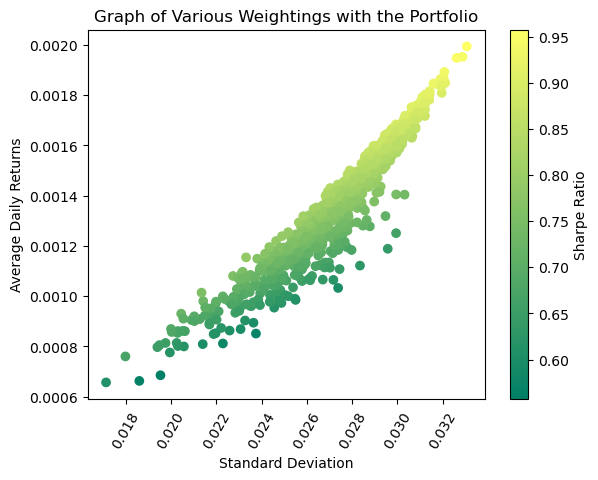

In [63]:
# We plot only 5 stocks for now
simulation_results, simulation_weights, min_risk, max_risk = simulateRandom(1000, close_prices.iloc[:, :5])  
plotSimulation(simulation_results)

If all goes well, the random tests should be bounded above by a discernable line. All of the portfolios on this line represent the most efficient portfolio; in other words, they represent the portfolio with the highest return for roughly the same amount of risk. The portfolio we choose should line up on that line. We can then find the weightings by looping through our results list and finding the portfolio that matches our needs. 

However, this process is slow and unexact. Thankfully, the line, also known as the efficient frontier, that bounds the portfolios has a few special properties. Modern Portfolio Theory argues that its shape is convex, and there has been a lot of mathematical research on optimizing convex problems. We can then use the pyportfolioopt library, which gives us tools to analyze this line.

# Implementation with the Pyportfolioopt Library
To have a bit more speed and accuracy in calculating the optimal portfolio, we will be using the Pyportfolioopt library (https://pyportfolioopt.readthedocs.io/en/latest/). This library implements portfolio optimization techniques, including Markowitz. This model is effective because as we have discovered, the efficient frontier can be modeled as a convex optimization problem. 

The general outline is that we create an ```EfficientFrontier``` class from the pyportfolioopt library, give it the expected returns of the various securities and their covariance with each other, and we input the risk that we want. Then, it will solve the optimization problem. Since we do want more returns as we are trying to aim for the market beat strategy, we have made the decision to increase our risk tolerance in exchange for more returns. 

## Determining Expected Returns
The first challenge is finding a way to determine expected returns. We could use the average historical prices, but that is under the assumption that future returns will replicate previous returns. We have decided to try out the Capital Asset Pricing Model as it avoids this assumption and may be more accurate. More specifically, CAPM states that the expected return of a security can be estimated with the following formula (https://www.investopedia.com/terms/c/capm.asp#toc-capital-asset-pricing-model-capm-formula):

$$R_i = R_f + \beta(R_m - R_f)$$
Where $R_i$ denotes the expected return of the individual security, $R_f$ is the risk-free rate, and $R_m$ is the return of the market. In other words, $R_m - R_f$ is the risk premium of the Market. The idea is that the covariance with the market is a better predictor of returns than the mean historical return.

To implement CAPM, we first define the risk-free rate as $(3.31\% + 4.41\%)/2 = 3.86\%$. This is the average of the Canadian 10-year benchmark bond rate (https://www.bankofcanada.ca/rates/interest-rates/lookup-bond-yields/) and the US 10-year bond rate (https://www.bloomberg.com/markets/rates-bonds/government-bonds/us). 

The following code first gets some market data, and then finds the beta of the securities in the stocks we choose. 

In [64]:
# Get market data
market_data = yf.download(tickers="^GSPC XIU.TO", start=start, end=end)["Close"]
# I could not find the ticker for the TSX60
# However, XIU.TO seems like a good substitute.

# We need to convert the currency into USD

cadusd = yf.download(tickers="CAD=x", start=start, end=end)
aligned_cadusd = cadusd.reindex(market_data.index, method='ffill')
aligned_cadusd_close = aligned_cadusd['Close'].reindex(market_data.index)

# Use a dataframe for easy calculation
market_data = pd.concat([market_data, aligned_cadusd_close], axis=1).dropna()
# convert USD to CAD
market_data["^GSPC"] = market_data["^GSPC"] * market_data["CAD=X"]

# Find the average
# Make sure they are weighted the same
market_data["^GSPC"] = market_data["^GSPC"] * 1000 / market_data["^GSPC"].iloc[0]
market_data["XIU.TO"] = market_data["XIU.TO"] * 1000 / market_data["XIU.TO"].iloc[0]
market_data["Market Average"] = (market_data["^GSPC"] + market_data["XIU.TO"]) / 2
display(market_data.head())

# -- Now, we find the beta -- #
# Get stock data
beta_df = pd.concat([stock_close_prices, market_data["Market Average"]], axis=1)
beta_df.dropna(axis=0, inplace=True)
# Find percent movement
beta_df_pct = convertToPct(beta_df)
# Find covariance
market_cov = beta_df_pct.cov()["Market Average"]
# Find market variance
market_var = beta_df_pct["Market Average"].var()
# Find betas = cov/var
betas = market_cov / market_var
display(betas)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed


Ticker,XIU.TO,^GSPC,CAD=X,Market Average
Date,,,,
2015-01-02,1000.000000,1000.000000,1.16140,1000.000000
2015-01-05,973.708502,996.852610,1.17930,985.280556
2015-01-06,965.405905,984.971141,1.17570,975.188523
2015-01-07,968.173408,1003.206354,1.18370,985.689881
2015-01-08,982.011099,1019.556029,1.18185,1000.783564


SHOP.TO           1.551239
SHOP              1.725773
SQ                2.021398
BAC               1.303306
JPM               1.164071
ORCL              0.966030
SPG               1.206539
GM                1.295925
AXP               1.305115
COST              0.717277
BK                1.089646
CSCO              1.001293
AMZN              1.128697
IBM               0.858011
TD.TO             0.804653
AAPL              1.196592
OXY               1.449001
RY.TO             0.763476
Market Average    1.000000
Name: Market Average, dtype: float64

Now, we want to find the CAPM for each stock. The following code first finds the market return as an average of market data. We will actually be using an exponentially weighted mean. This method allows more recent data to be weighted more heavily, since it makes sense that more recent data would be related to future data. 

To calculate exponentially weighted mean, we use the following formula:

$$a_t = \frac{c_t + c_{t-1}(1-\alpha) + c_{t-2}(1-\alpha)^2 + ... + c_0(1-\alpha)^t}{1 + (1-\alpha) + (1-\alpha)^2 + ... + (1-\alpha)^t}$$
Where $t$ is the amount of periods, $c_i$ is the percent change at time $= i$, and $\alpha$ is a factor between $0$ and $1$ that will determine how weighted previous periods are weighted. 

This is the code, which uses the pandas library.

In [65]:
market_data = market_data.resample("MS").ffill()
market_data.dropna(axis=0, inplace=True)
market_data_pct = convertToPct(market_data)
market_data_pct.index = pd.to_datetime(market_data_pct.index)
market_return = market_data_pct.ewm(alpha=0.8, adjust=True).mean()["^GSPC"].iloc[-1]  # We want the last value
print("Market Return (month):", market_return)  # Remember that this is a percent, not a decimal

Market Return (month): 0.029698826779930153


We can now find the expected returns using the CAPM.

In [66]:
risk_free = 0.0386
returns = risk_free/12 + betas[:-1]  * (market_return - risk_free/12) # The risk free rate is for a year, so we divide by 12
display(returns) 

SHOP.TO    0.044297
SHOP       0.048919
SQ         0.056748
BAC        0.037731
JPM        0.034044
ORCL       0.028799
SPG        0.035168
GM         0.037536
AXP        0.037779
COST       0.022212
BK         0.032073
CSCO       0.029733
AMZN       0.033107
IBM        0.025939
TD.TO      0.024526
AAPL       0.034905
OXY        0.041589
RY.TO      0.023435
Name: Market Average, dtype: float64

We now have enough information to use the pyportfolioopt library. The following code file will return the Efficient Frontier object, which we will call multiple times to get various numbers. pyportfolioopt uses a covariance matrix to determine risk, which we will store with the variable cov_matrix.

In [67]:
def optimizedEF(returns: pd.Series, risk: pd.DataFrame, min_weight: float = 0, max_weight: float = 0.15):
    # This will return the efficient frontier (i.e. most return for different amount of risk)

    # Because there's limits, we have to incorporate them
    EF = EfficientFrontier(returns, risk, weight_bounds=(min_weight, max_weight))
    return EF

cov_matrix = convertToPct(stock_close_prices).cov()
display(cov_matrix.iloc[:5, :5])

,SHOP.TO,SHOP,SQ,BAC,JPM
SHOP.TO,0.001300,0.001320,0.000737,0.000160,0.000128
SHOP,0.001320,0.001385,0.000793,0.000189,0.000155
SQ,0.000737,0.000793,0.001360,0.000263,0.000223
BAC,0.000160,0.000189,0.000263,0.000407,0.000321
JPM,0.000128,0.000155,0.000223,0.000321,0.000317


Then, we can use this to solve for various portfolios. Our hypothesis is that to get a portfolio that beats the market, we have to accept more risk, even more than the optimal Sharpe ratio accounts for. To do so, we can get the risk for the optimal sharpe ratio . Then, we can use a ratio to choose a risk value that best meets our needs, i.e. create a target risk that is higher than the risk to create the optimal sharpe ratio portfolio. The ratio that we are using is gained through our own testing.  

In [68]:
min_weight = 1 / (2 * len(stock_close_prices.columns))  # Find the minimum weight bound

# Find sharpe ratio portfolio
sharpe_ef = optimizedEF(returns, cov_matrix, min_weight)
sharpe_weights = sharpe_ef.max_sharpe(risk_free/100)
sharpe_risk = sharpe_ef.portfolio_performance(risk_free_rate=risk_free/100)[1]

# Find target risk
target_risk = sharpe_risk * 1.1
target_ef = optimizedEF(returns, cov_matrix, min_weight)
target_weights = target_ef.efficient_risk(target_risk)
wanted_weights = target_ef.clean_weights()
target_performance = target_ef.portfolio_performance(risk_free_rate=risk_free/100)

# Turn results into a pd.dataframe
weightings_df = pd.DataFrame(columns=["Weight"])
for ticker in wanted_weights:
    weightings_df.loc[ticker] = {"Weight": wanted_weights[ticker]}

# Display results
display(weightings_df)

,Weight
SHOP.TO,0.02778
SHOP,0.02778
SQ,0.04944
BAC,0.02778
JPM,0.03639
ORCL,0.04943
SPG,0.03135
GM,0.02778
AXP,0.06264
COST,0.05679


### Last step: buy shares and generate portfolio

The following function buys our stocks based on the determined weightings 

In [69]:
def buy_shares(weightings_df, prices_df):
    """
    Allocates a fixed cash amount to a portfolio of stocks based on their target weightings, 
    considering transaction fees, and returns a final portfolio with adjusted investments.

    Parameters:
        weightings_df (pd.DataFrame): DataFrame with stock tickers as index and a column `Weight` representing 
                                      the target percentage allocation for each stock.
        prices_df (pd.Series): Series with stock tickers as index and their respective close prices.
        currencies_df (pd.DataFrame): DataFrame with stock tickers as index and a `Currency` column 
                                       indicating the trading currency of each stock.

    Returns:
        pd.DataFrame: A DataFrame containing the final portfolio allocation:
                      - Ticker: Stock tickers
                      - Price: Closing price of each stock
                      - Currency: Trading currency of each stock
                      - Shares: Adjusted number of shares purchased for each stock
                      - Value: Adjusted investment amount for each stock
                      - Weight: Target weight percentage for each stock

    """

    # Constants for cash amount and transaction fees
    cash = 1000000  # Total cash available for investment
    flat_fee = 3.95  # Flat transaction fee per stock
    fee_per_share = 0.001  # Fee per share

    # 1: Retrieve close prices and calculate initial investment amounts and shares
    weightings_df['Close Price'] = prices_df.reindex(weightings_df.index)
    weightings_df['Investment Amt'] = cash * (weightings_df['Weight'] / 100)
    weightings_df['Shares'] = weightings_df['Investment Amt'] / weightings_df['Close Price']

    # 2: Calculate transaction fees, choosing the cheaper of the flat fee or per-share fee
    weightings_df['fees'] = np.minimum(weightings_df['Shares'] * fee_per_share, flat_fee)

    # 3: Calculate total investment including fees
    weightings_df['Investment with fees'] = weightings_df['Shares'] * weightings_df['Close Price'] + weightings_df['fees']
    total_with_fees = weightings_df['Investment with fees'].sum()

    # 4: Adjust investments to stay within the cash budget
    adjustment_factor = cash / total_with_fees
    weightings_df['Adjusted Investment Amt'] = weightings_df['Investment Amt'] * adjustment_factor
    weightings_df['Adjusted Shares'] = weightings_df['Adjusted Investment Amt'] / weightings_df['Close Price']

    # 5: Recalculate fees based on adjusted shares
    weightings_df['Adjusted fees'] = np.minimum(weightings_df['Adjusted Shares'] * fee_per_share, flat_fee)

    # 6: Calculate final investment for each stock
    weightings_df['Final Investment'] = weightings_df['Adjusted Shares'] * weightings_df['Close Price'] + weightings_df['Adjusted fees']

    # 7: Create the final portfolio DataFrame
    Portfolio_Final = pd.DataFrame()
    Portfolio_Final['Ticker'] = weightings_df.index
    Portfolio_Final.index = Portfolio_Final['Ticker']  # Use tickers as the index
    Portfolio_Final['Price'] = weightings_df['Close Price']
    Portfolio_Final['Currency'] = 'CAD'
    Portfolio_Final['Shares'] = weightings_df['Adjusted Shares']
    Portfolio_Final['Value'] = weightings_df['Adjusted Investment Amt']
    Portfolio_Final['Weight'] = weightings_df['Weight']

    # Reindex the final portfolio for cleaner display
    Portfolio_Final.index = range(1, len(Portfolio_Final) + 1)

    return Portfolio_Final

final_close_prices = yf.download(tickers=" ".join(weightings_df.index), start='2024-11-15', end="2024-11-22")["Close"]

# Generate the final portfolio
Portfolio_Final = buy_shares(weightings_df, final_close_prices.iloc[-1])


[*********************100%***********************]  18 of 18 completed


### Show portfolio total weight and value

In [70]:
#tests
total = Portfolio_Final['Value'].sum()
total_weight = Portfolio_Final['Weight'].sum()

### Generating Final_Portfolio CSV file

In [71]:
def generate_csv(portfolio_final):
    Stocks_Final = pd.DataFrame()
    Stocks_Final['Ticker'] = portfolio_final['Ticker']
    Stocks_Final['Shares'] = portfolio_final["Shares"]
    Stocks_Final.reset_index(drop=True, inplace=True)

    file_name = 'Stocks_Group_02.csv'
    Stocks_Final.to_csv(file_name, index=False)
    return Stocks_Final

Stocks_Final = generate_csv(Portfolio_Final)

print("Here is our final Portfolio")
display(Portfolio_Final)
print("Total Portfolio Value: $", round(total,2), "\nTotal Portfolio Weight: ", total_weight, sep='')


Here is our final Portfolio


,Ticker,Price,Currency,Shares,Value,Weight
1,SHOP.TO,148.809998,CAD,186.677552,27779.485997,0.02778
2,SHOP,106.480003,CAD,260.889229,27779.485997,0.02778
3,SQ,92.699997,CAD,533.323483,49439.085230,0.04944
4,BAC,46.459999,CAD,597.922655,27779.485997,0.02778
5,JPM,244.759995,CAD,148.673507,36389.326689,0.03639
6,ORCL,192.429993,CAD,256.867886,49429.085415,0.04943
7,SPG,181.800003,CAD,172.439051,31349.419943,0.03135
8,GM,55.680000,CAD,498.913180,27779.485997,0.02778
9,AXP,293.000000,CAD,213.784440,62638.840995,0.06264
10,COST,955.650024,CAD,59.424421,56788.949236,0.05679


Total Portfolio Value: $999991.5
Total Portfolio Weight: 1.0000099999999998


To just gauge how well our portfolio did, we have inserted a graph that tracks the performance. Hopefully all has worked well and this graph shows good performance with the stocks given.

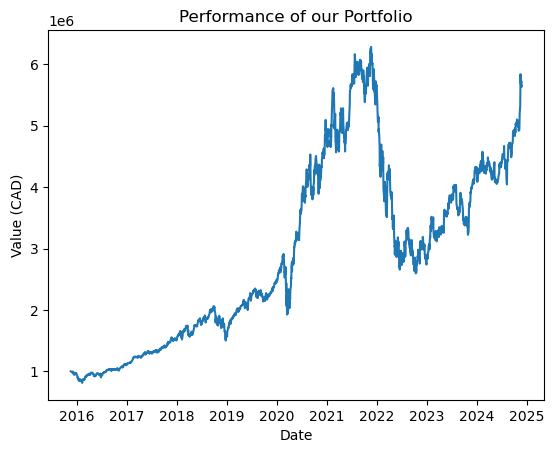

In [72]:
weights = Portfolio_Final["Weight"].to_list()
# For convenience, we do not factor the transaction prices
final_stocks = applyWeightings(stock_close_prices, weights, 1000000)   
plt.plot(final_stocks.sum(axis=1))
plt.title("Performance of our Portfolio")
plt.xlabel("Date")
plt.ylabel("Value (CAD)")
plt.show()


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Gateek, Jason, Patrick.